In [1]:
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from IPython.core.display import Markdown
from IPython.core.display_functions import display
from sklearn.model_selection import train_test_split

import notebooks.config as config
import notebooks.utils as nb_utils
from src.config import FeaturesInfo
from src.features.univariate_analysis import UACleaner
from src.utils import init_cols_nan_strategy, preprocess_init

STAGE = 1
PREVIOUS_STAGE = STAGE - 1

%load_ext autoreload
%autoreload 2

## Load cleaned data and metadata in artifacts

In [2]:
def load_dataset_and_metadata() -> Tuple[pd.DataFrame, FeaturesInfo]:
    df, features_info = nb_utils.load_dataset_and_metadata(
        nb_utils.STAGES_DICT[PREVIOUS_STAGE]["name"],
        nb_utils.STAGES_DICT[PREVIOUS_STAGE]["folder_path"],
    )
    return df, features_info

In [3]:
df, features_info = load_dataset_and_metadata()

df.info(memory_usage="deep", max_cols=200)
print()

max_nans_for_rows = df.isna().sum(axis=1).max()
print(f"Max NaNs for rows: {max_nans_for_rows}")
print()

pd.options.display.max_rows = None

print("NaNs for cols")
nans_for_cols = nb_utils.get_nas(df)
display(nans_for_cols[nans_for_cols > 0])

pd.reset_option("display.max_rows", 0)

<class 'pandas.core.frame.DataFrame'>
Index: 29991 entries, 9249043 to 23246511
Data columns (total 170 columns):
 #    Column                                   Non-Null Count  Dtype         
---   ------                                   --------------  -----         
 0    name                                     29991 non-null  string        
 1    short_url                                29991 non-null  string        
 2    price                                    29991 non-null  UInt32        
 3    listing_followers_no                     27205 non-null  UInt16        
 4    location                                 29991 non-null  category      
 5    images_no                                29991 non-null  UInt8         
 6    description                              29991 non-null  string        
 7    gi_brand                                 29991 non-null  category      
 8    gi_model                                 29991 non-null  category      
 9    gi_production_year    

,missing count,missing [%]
ai_range_on_full_battery_km,29864,99.576540
gi_battery_capacity,29834,99.476510
ai_interest_free_credit,29805,99.379814
ai_cash_payment,29708,99.056384
ai_deposit,29518,98.422860
ai_installment_amount,29413,98.072755
ai_installment_no,29381,97.966056
ai_leasing,29204,97.375879
gi_certified,28474,94.941816
ai_credit,28174,93.941516


In [4]:
def train_test_split_nb(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df_train, df_test = train_test_split(
        df,
        test_size=config.TEST_SIZE,
        random_state=config.RANDOM_SEED,
    )
    return df_train, df_test

In [5]:
df_orig = df
# Using alias for df_train for making things easier and more neat
df, df_test = train_test_split_nb(df)

cols_nan_strategy = init_cols_nan_strategy()
idx_to_remove = []

In [6]:
n_rows_train, n_cols_train = df.shape

print("Train dataset shape")
print(20 * "-")
print(f"No of rows: {n_rows_train}")
print(f"No of cols: {n_cols_train}")

print()

n_rows_test, n_cols_test = df_test.shape

print("Test dataset shape")
print(20 * "-")
print(f"No of rows: {n_rows_test}")
print(f"No of cols: {n_cols_test}")
print(20 * "-")

Train dataset shape
--------------------
No of rows: 23992
No of cols: 170

Test dataset shape
--------------------
No of rows: 5999
No of cols: 170
--------------------


### nominal features

In [7]:
@preprocess_init
def ua_nominal_features_nb(
    df: pd.DataFrame,
    features_info: FeaturesInfo,
    cols_nan_strategy: Dict[str, List[str]],
    idx_to_remove: List[int],
) -> Tuple[pd.DataFrame, FeaturesInfo, Dict[str, List[str]], List[int]]:
    print("Frequencies for nominal features")
    for col in features_info["nominal"]:
        df[col] = df[col].cat.remove_unused_categories()
        display(nb_utils.get_value_counts_freq_with_perc(df, col))
    print("Dropped empty categories")
    print()

    df.loc[df.gi_body_type == "", "gi_body_type"] = np.nan
    print("Replaced ' ' category for 'gi_body_type' with NaN")

    df.gi_fuel_type = pd.Categorical(
        df.gi_fuel_type.astype("string").replace(
            {
                "Hibridni pogon (Benzin)": "Hibridni pogon",
                "Hibridni pogon (Dizel)": "Hibridni pogon",
                "Plug-in hibrid": "Hibridni pogon",
                "Metan CNG": "Benzin + Metan (CNG)",
            }
        ),
        ordered=False,
    )
    print("Grouped simillar categories for 'gi_fuel_type'")

    df.ai_gearbox_type = pd.Categorical(
        df.ai_gearbox_type.astype("string").replace(
            {
                "Automatski": "Automatski / poluautomatski",
                "Poluautomatski": "Automatski / poluautomatski",
            }
        )
    )
    print("Grouped simillar categories for 'ai_gearbox_type'")

    constant_strat_cols = [
        "ai_floating_flywheel",
        "ai_interior_material",
        "ai_interior_color",
        "ai_ownership",
        "ai_import_country",
        "ai_sales_method",
    ]
    modus_strat_cols = [
        col for col in features_info["nominal"] if col not in constant_strat_cols
    ]
    cols_nan_strategy["const_unknown"].extend(constant_strat_cols)
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("NaN constant strategy columns:")
    print(constant_strat_cols)
    print("Extended 'constant' and 'modus' cols_nan_strategy")

    return df, features_info, cols_nan_strategy, idx_to_remove

In [8]:
df, features_info, cols_nan_strategy, idx_to_remove = ua_nominal_features_nb(
    df=df,
    features_info=features_info,
    cols_nan_strategy=cols_nan_strategy,
    idx_to_remove=idx_to_remove,
)

Frequencies for nominal features


,count,percentage [%]
location,,
Beograd,3925,16.359620
Novi Sad,1682,7.010670
Niš,977,4.072191
Kragujevac,890,3.709570
Čačak,716,2.984328
...,...,...
Rudnik,1,0.004168
Rudna Glava,1,0.004168
Riđica,1,0.004168


,count,percentage [%]
gi_brand,,
Volkswagen,3855,16.067856
Audi,2503,10.432644
BMW,2173,9.057186
Opel,1886,7.860954
Peugeot,1612,6.718906
...,...,...
Great Wall,1,0.004168
Geely,1,0.004168
Cadillac,1,0.004168


,count,percentage [%]
gi_model,,
A4,677,2.821774
Octavia,499,2.079860
A3,496,2.067356
A6,480,2.000667
Golf 7,465,1.938146
...,...,...
E 230,1,0.004168
SL 280,1,0.004168
SL 300,1,0.004168


,count,percentage [%]
gi_body_type,,
Hečbek,8212,34.228076
Džip/SUV,4740,19.756586
Limuzina,4429,18.460320
Karavan,3633,15.142548
Monovolumen (MiniVan),1944,8.102701
Kupe,645,2.688396
Kabriolet/Roadster,247,1.029510
Pickup,140,0.583528
,2,0.008336


,count,percentage [%]
gi_fuel_type,,
Dizel,16394,68.331110
Benzin,5895,24.570690
Benzin + Gas (TNG),895,3.730410
Benzin + Metan (CNG),443,1.846449
Hibridni pogon,196,0.816939
Električni pogon,129,0.537679
Hibridni pogon (Benzin),24,0.100033
Hibridni pogon (Dizel),13,0.054185
Plug-in hibrid,2,0.008336


,count,percentage [%]
gi_trade_in,,
NE,17683,73.703735
DA,2981,12.424975
DA (za jeftinije),2206,9.194732
DA (za skuplje),775,3.230243
DA (u istoj ceni),347,1.446315


,count,percentage [%]
ai_floating_flywheel,,
<NA>,16319,68.018506
Sa plivajućim zamajcem,4941,20.594365
Bez plivajućeg zamajca,2732,11.387129


,count,percentage [%]
ai_gearbox_type,,
Manuelni 5 brzina,8499,35.424308
Manuelni 6 brzina,8116,33.827943
Automatski / poluautomatski,7252,30.226742
Manuelni 4 brzine,111,0.462654
Automatski,13,0.054185
Poluautomatski,1,0.004168


,count,percentage [%]
ai_air_conditioning,,
Automatska klima,16266,67.797599
Manuelna klima,6940,28.926309
Nema klimu,786,3.276092


,count,percentage [%]
ai_color,,
Siva,7659,31.923141
Crna,6265,26.112871
Bela,3565,14.859120
Plava,2177,9.073858
Crvena,1094,4.559853
Srebrna,594,2.475825
Teget,576,2.400800
Braon,462,1.925642
Zelena,386,1.608870


,count,percentage [%]
ai_interior_material,,
Štof,12955,53.997166
Prirodna koža,4103,17.101534
<NA>,3266,13.612871
Kombinovana koža,2933,12.224908
Drugi,380,1.583861
Velur,355,1.479660


,count,percentage [%]
ai_interior_color,,
Crna,12217,50.921140
Siva,4596,19.156385
<NA>,4182,17.430810
Druga,1351,5.631044
Bež,1139,4.747416
Smeđa,507,2.113204


,count,percentage [%]
ai_propulsion,,
Prednji,17406,72.549183
4x4,4012,16.722241
Zadnji,2091,8.715405
4x4 reduktor,483,2.013171


,count,percentage [%]
ai_vehicle_origin,,
Domaće tablice,14673,61.157886
Na ime kupca,9171,38.225242
Strane tablice,146,0.608536
<NA>,2,0.008336


,count,percentage [%]
ai_ownership,,
Vodi se na prodavca,10279,42.843448
<NA>,9338,38.921307
Ne vodi se na prodavca,4375,18.235245


,count,percentage [%]
ai_import_country,,
<NA>,17948,74.808269
Švajcarska,1609,6.706402
Italija,1109,4.622374
Francuska,995,4.147216
Nemačka,846,3.526175
Holandija,534,2.225742
Belgija,294,1.225408
Norveška,209,0.871124
Austrija,155,0.646049


,count,percentage [%]
ai_sales_method,,
<NA>,21563,89.875792
Komisiona,2210,9.211404
Konsignaciona,219,0.912804


Dropped empty categories

Replaced ' ' category for 'gi_body_type' with NaN
Grouped simillar categories for 'gi_fuel_type'
Grouped simillar categories for 'ai_gearbox_type'
NaN constant strategy columns:
['ai_floating_flywheel', 'ai_interior_material', 'ai_interior_color', 'ai_ownership', 'ai_import_country', 'ai_sales_method']
Extended 'constant' and 'modus' cols_nan_strategy


### ordinal features

In [9]:
@preprocess_init
def ua_ordinal_features_nb(
    df: pd.DataFrame,
    features_info: FeaturesInfo,
    cols_nan_strategy: Dict[str, List[str]],
    idx_to_remove: List[int],
) -> Tuple[pd.DataFrame, FeaturesInfo, Dict[str, List[str]], List[int]]:
    print("Frequencies for ordinal features")
    for col in features_info["ordinal"]:
        df[col] = df[col].cat.remove_unused_categories()
        display(nb_utils.get_value_counts_freq_with_perc(df, col))
    print("Dropped empty categories")
    print()

    modus_strat_cols = ["ai_engine_emission_class", "ai_damage"]
    cols_nan_strategy["modus"].extend(modus_strat_cols)
    print("NaN modus strategy columns:")
    print(modus_strat_cols)
    print("Extended 'modus' cols_nan_strategy")

    return df, features_info, cols_nan_strategy, idx_to_remove

In [10]:
df, features_info, cols_nan_strategy, idx_to_remove = ua_ordinal_features_nb(
    df=df,
    features_info=features_info,
    cols_nan_strategy=cols_nan_strategy,
    idx_to_remove=idx_to_remove,
)

Frequencies for ordinal features


,count,percentage [%]
ai_engine_emission_class,,
4,7169,29.880794
6,7139,29.755752
5,6658,27.750917
3,2514,10.478493
2,299,1.246249
1,209,0.871124
<NA>,4,0.016672


,count,percentage [%]
ai_damage,,
Nije oštećen,23704,98.799600
Oštećen - u voznom stanju,174,0.725242
Oštećen - nije u voznom stanju,109,0.454318
<NA>,5,0.020840


Dropped empty categories

NaN modus strategy columns:
['ai_engine_emission_class', 'ai_damage']
Extended 'modus' cols_nan_strategy


### numerical features

In [11]:
@preprocess_init
def ua_numerical_features_nb(
    df: pd.DataFrame,
    features_info: FeaturesInfo,
    cols_nan_strategy: Dict[str, List[str]],
    idx_to_remove: List[int],
) -> Tuple[pd.DataFrame, FeaturesInfo, Dict[str, List[str]], List[int]]:
    for col in features_info["numerical"]:
        # display(Markdown("#### Feature 'images_no'"))
        nb_utils.show_hist_box_numerical_col(df, col)
        print()

    const_strat_cols_zero = ["listing_followers_no"]
    cols_scheduled_for_deletion = [
        "gi_battery_capacity",
        "ai_deposit",
        "ai_installment_no",
        "ai_cash_payment",
    ]
    median_strat_cols = [
        col
        for col in features_info["numerical"]
        if col not in const_strat_cols_zero + cols_scheduled_for_deletion
    ]

    df_cars_with_0_kilometerage = df[df.gi_kilometerage == 0]
    print(f"Cars with 'gi_kilometerage' = 0: {df_cars_with_0_kilometerage.shape[0]}")

    df.drop(df_cars_with_0_kilometerage.index, inplace=True)
    idx_to_remove.extend(df_cars_with_0_kilometerage.index.to_list())
    print("Removed cars with 'gi_kilometerage' = 0")
    print()

    display(df.loc[df.gi_engine_capacity > 0.2 * 1e8])
    df.loc[df.gi_engine_capacity > 0.2 * 1e8, "gi_engine_capacity"] = np.nan
    print(
        "Replaced extreme value of 'gi_engine_capacity' with NaN (will be replaced with median)"
    )
    print()

    print(
        "Cars where 'gi_production_year' = 2024: ",
        (df.gi_production_year == 2024).sum(),
    )
    print()

    listing_names_less_30_hp = df.loc[df.gi_engine_power < 30, "name"].values
    print(
        f"Listing names of cars where 'gi_engine_power' < 30 (horse power): {listing_names_less_30_hp}"
    )
    print()

    features_info["features_to_delete"].extend(cols_scheduled_for_deletion)
    print("Dropped 'gi_battery_capacity' (too many zero values)")
    print("Dropped 'ai_deposit' (label leakage)")
    print("Dropped 'ai_installment_no' (label leakage)")
    print("Dropped 'ai_cash_payment' (label leakage)")
    print("Dropped 'ai_range_on_full_battery_km' (too many zero values)")

    cols_nan_strategy["const_0"].extend(const_strat_cols_zero)
    cols_nan_strategy["median"].extend(median_strat_cols)
    print("NaN fill by 0 strategy columns:")
    print(const_strat_cols_zero)
    print("Extended 'modus' cols_nan_strategy")

    return df, features_info, cols_nan_strategy, idx_to_remove

Univariate analysis of 'listing_followers_no' column
Histogram and box plot


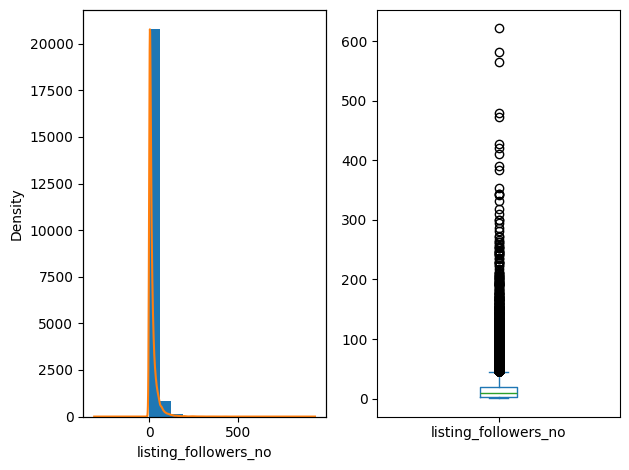

Descriptive statistics


count      21792.0
mean      17.31328
std      26.939594
min            1.0
25%            3.0
50%            9.0
75%           20.0
max          621.0
Name: listing_followers_no, dtype: Float64

Variance: 1.5560075331711065
Skewness: 5.907852765828183
Kurtosis: 67.24426397244302

NA values
Count [n]: 2200
Percentage [%]: 9.16972324108036%

Univariate analysis of 'images_no' column
Histogram and box plot


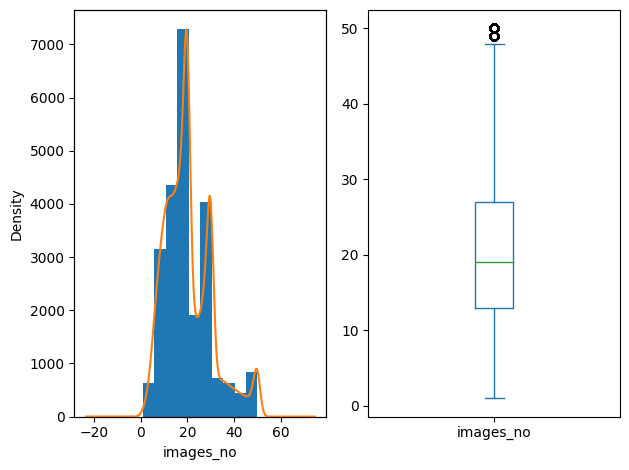

Descriptive statistics


count      23992.0
mean     20.403468
std      10.129927
min            1.0
25%           13.0
50%           19.0
75%           27.0
max           50.0
Name: images_no, dtype: Float64

Variance: 0.49648063807975495
Skewness: 0.8825518305117348
Kurtosis: 0.6906011752226675

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_kilometerage' column
Histogram and box plot


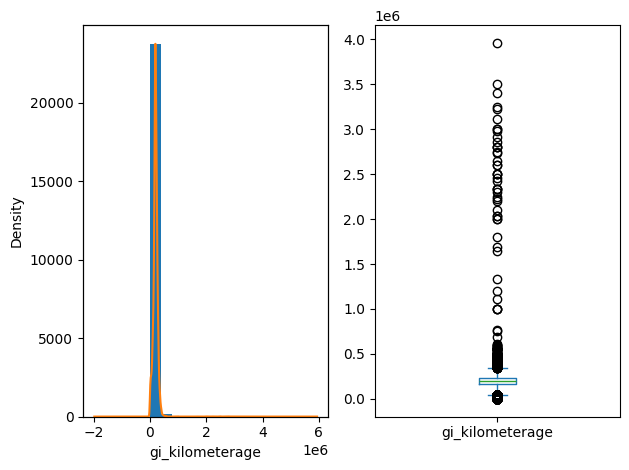

Descriptive statistics


count          23992.0
mean     198895.270465
std      122724.322481
min                0.0
25%           160000.0
50%           195205.5
75%          235014.25
max          3960000.0
Name: gi_kilometerage, dtype: Float64

Variance: 0.6170298680002697
Skewness: 13.594133356134774
Kurtosis: 295.3914923857302

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_production_year' column
Histogram and box plot


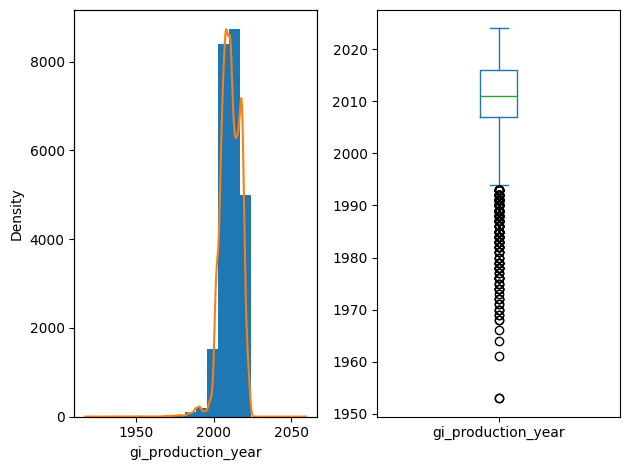

Descriptive statistics


count       23992.0
mean     2010.67906
std        6.292738
min          1953.0
25%          2007.0
50%          2011.0
75%          2016.0
max          2024.0
Name: gi_production_year, dtype: Float64

Variance: 0.0031296579484031183
Skewness: -0.8762664906839511
Kurtosis: 3.290585219197072

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_engine_capacity' column
Histogram and box plot


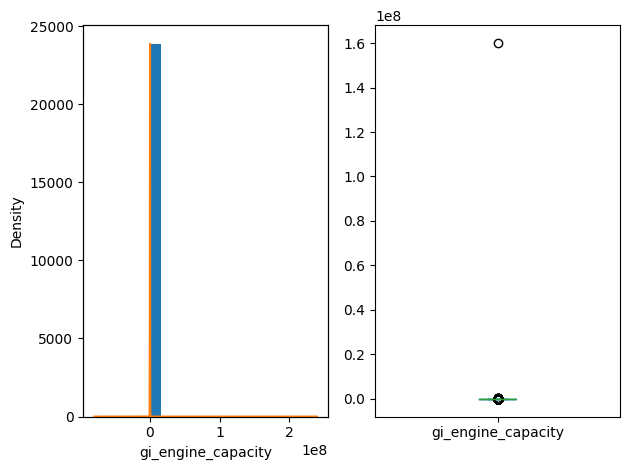

Descriptive statistics


count           23863.0
mean        8550.027909
std      1036083.567578
min               100.0
25%              1461.0
50%              1796.0
75%              1991.0
max         160051414.0
Name: gi_engine_capacity, dtype: Float64

Variance: 121.17896907084098
Skewness: 154.4638489637424
Kurtosis: 23857.386448110916

NA values
Count [n]: 129
Percentage [%]: 0.537679226408803%

Univariate analysis of 'gi_engine_power' column
Histogram and box plot


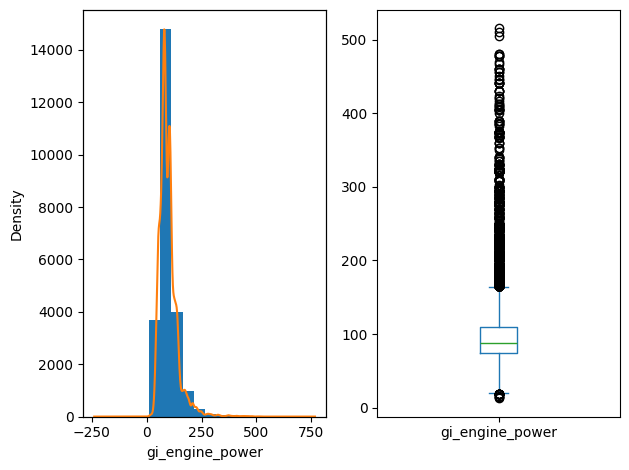

Descriptive statistics


count    23992.000000
mean        98.338780
std         42.911228
min         13.000000
25%         74.000000
50%         88.000000
75%        110.000000
max        515.000000
Name: gi_engine_power, dtype: float64

Variance: 0.43636119657076144
Skewness: 2.5915870786657473
Kurtosis: 12.823051642639241

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'gi_battery_capacity' column
Histogram and box plot


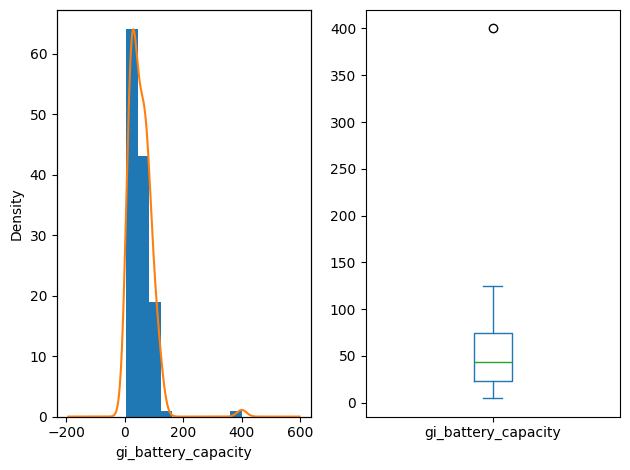

Descriptive statistics


count        128.0
mean     53.985625
std       43.21691
min            5.0
25%          22.75
50%           44.0
75%           75.0
max          400.0
Name: gi_battery_capacity, dtype: Float64

Variance: 0.8005262525284741
Skewness: 4.137193939906376
Kurtosis: 30.130749041974397

NA values
Count [n]: 23864
Percentage [%]: 99.46648882960987%

Univariate analysis of 'ai_seats_no' column
Histogram and box plot


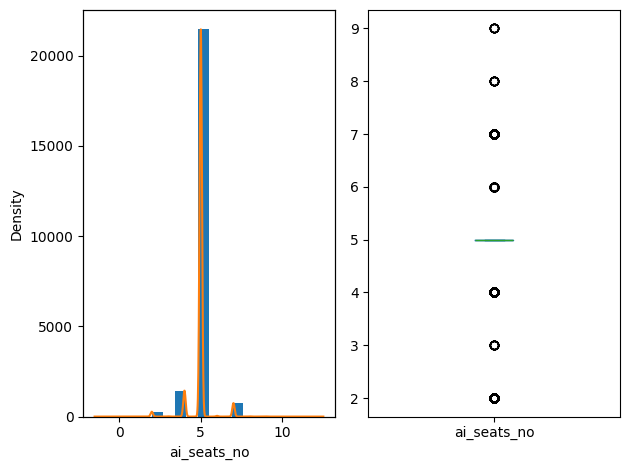

Descriptive statistics


count     23992.0
mean     4.971699
std      0.545912
min           2.0
25%           5.0
50%           5.0
75%           5.0
max           9.0
Name: ai_seats_no, dtype: Float64

Variance: 0.10980382102386822
Skewness: -0.35649287563161136
Kurtosis: 14.917760096834122

NA values
Count [n]: 0
Percentage [%]: 0.0%

Univariate analysis of 'ai_deposit' column
Histogram and box plot


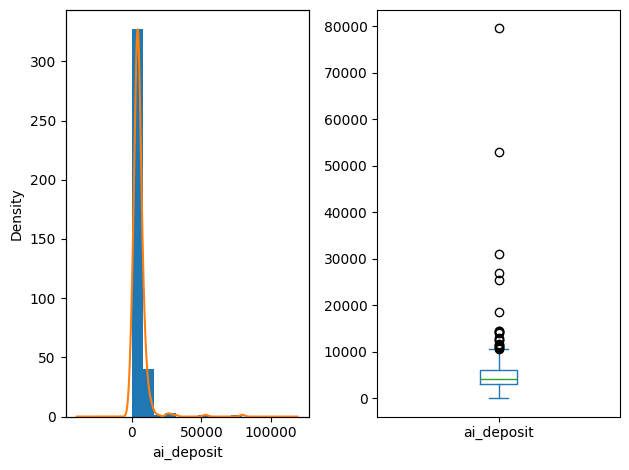

Descriptive statistics


count          373.0
mean     5130.163539
std      5782.097529
min              1.0
25%           3000.0
50%           4200.0
75%           6000.0
max          79480.0
Name: ai_deposit, dtype: Float64

Variance: 1.1270785980390914
Skewness: 7.806320583577433
Kurtosis: 85.65661586433448

NA values
Count [n]: 23619
Percentage [%]: 98.44531510503501%

Univariate analysis of 'ai_installment_no' column
Histogram and box plot


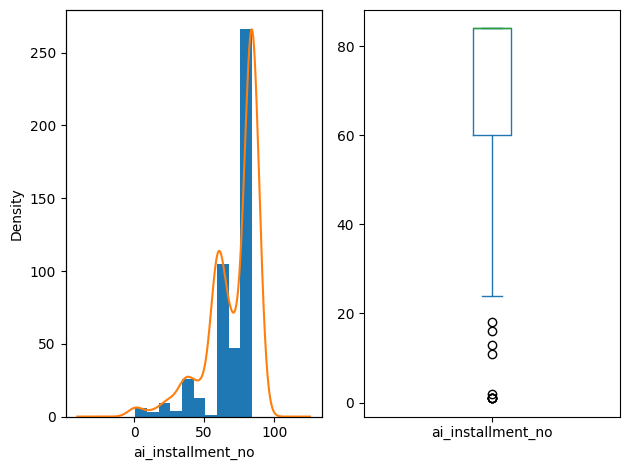

Descriptive statistics


count        480.0
mean     70.847917
std      18.232773
min            1.0
25%           60.0
50%           84.0
75%           84.0
max           84.0
Name: ai_installment_no, dtype: Float64

Variance: 0.25735087538250007
Skewness: -1.5329176702186502
Kurtosis: 2.208347620961103

NA values
Count [n]: 23512
Percentage [%]: 97.99933311103702%

Univariate analysis of 'ai_installment_amount' column
Histogram and box plot


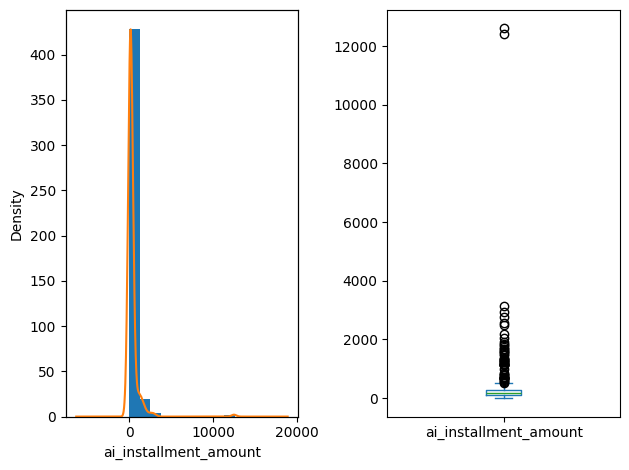

Descriptive statistics


count         453.0
mean     365.573951
std      917.589766
min             1.0
25%           118.0
50%           173.0
75%           280.0
max         12600.0
Name: ai_installment_amount, dtype: Float64

Variance: 2.5099976705080373
Skewness: 10.578886972983739
Kurtosis: 133.44504237762607

NA values
Count [n]: 23539
Percentage [%]: 98.11187062354118%

Univariate analysis of 'ai_cash_payment' column
Histogram and box plot


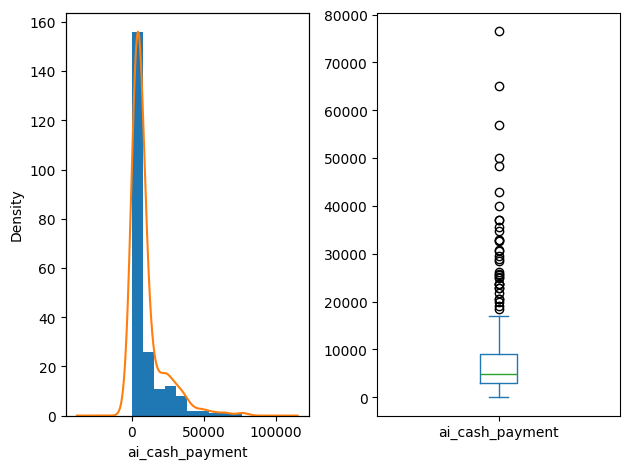

Descriptive statistics


count           220.0
mean      9396.245455
std      11750.754528
min               1.0
25%            3000.0
50%            4950.0
75%            9000.0
max           76600.0
Name: ai_cash_payment, dtype: Float64

Variance: 1.2505797752067631
Skewness: 2.6513694866691
Kurtosis: 8.271473378491521

NA values
Count [n]: 23772
Percentage [%]: 99.08302767589197%

Univariate analysis of 'ai_range_on_full_battery_km' column
Histogram and box plot


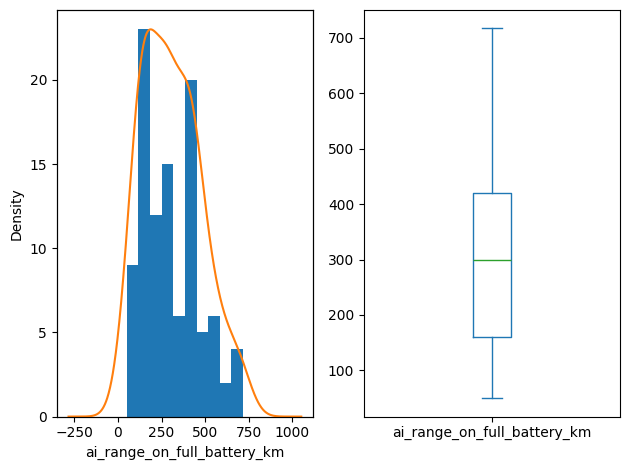

Descriptive statistics


count         102.0
mean     308.558824
std      166.874208
min            50.0
25%           160.0
50%           300.0
75%           420.0
max           717.0
Name: ai_range_on_full_battery_km, dtype: Float64

Variance: 0.5408181382461654
Skewness: 0.4848960845053993
Kurtosis: -0.4745457639440609

NA values
Count [n]: 23890
Percentage [%]: 99.57485828609536%

Cars with 'gi_kilometerage' = 0: 1
Removed cars with 'gi_kilometerage' = 0



,name,short_url,price,listing_followers_no,location,images_no,description,gi_brand,gi_model,gi_production_year,...,o_Oldtimer,o_Prilagođeno_invalidima,o_Prvi_vlasnik,o_Restauriran,o_Rezervni_ključ,o_Servisna_knjiga,o_Taxi,o_Test_vozilo,o_Tuning,o_Vozilo_auto_škole
id,,,,,,,,,,,,,,,,,,,,,
23210877,Opel Insignia EXCLUSIVE,https://www.polovniautomobili.com/auto-oglasi/...,15200,4,Leštane,30,Opel Insignija 1.6D 136 KS 6 brz. Auto je u na...,Opel,Insignia,2019,...,False,False,False,False,True,True,False,False,False,False


Replaced extreme value of 'gi_engine_capacity' with NaN (will be replaced with median)

Cars where 'gi_production_year' = 2024:  4

Listing names of cars where 'gi_engine_power' < 30 (horse power): <StringArray>
[ 'Zastava 750 presla 38.400',            'Zastava 750 750',
          'Fiat Seicento 0.9',             'Zastava 750 LE',
                'Zastava 750',         'Zastava 750 750 le',
                'Zastava 750',               'ZhiDou Icaro',
              'Renault Twizy',   'Citroen Ami ami electric',
           'Fiat 126 Peglica',     'Renault Twizy eletktro',
      'Zastava 750 LE sa Reg',                'Trabant 601',
            'Renault R 4 GTL',             'Renault R 4 tl',
           'Fiat Cinquecento',            'Fiat 126 126PLG',
 'Renault Twizy elektro  8kw',          'Fiat 500L Berlina',
                'Zastava 850',                'Zastava 750',
                'Zastava 750',      'Volkswagen Buba 1200J',
         'Citroen 2CV spaček',            'Renault R 4 G

In [12]:
df, features_info, cols_nan_strategy, idx_to_remove = ua_numerical_features_nb(
    df=df,
    features_info=features_info,
    cols_nan_strategy=cols_nan_strategy,
    idx_to_remove=idx_to_remove,
)

## Testing

### Test individual components

In [13]:
class TestNotebook:
    # Testing only df_train
    def test_ua_features(self, features_type):
        df_1, features_info_1 = load_dataset_and_metadata()
        df_2, features_info_2 = load_dataset_and_metadata()
        cols_nan_strategy_1 = init_cols_nan_strategy()
        cols_nan_strategy_2 = init_cols_nan_strategy()
        idx_to_remove_1 = []
        idx_to_remove_2 = []

        # Get df_train
        df_1, _ = train_test_split_nb(df_1)
        df_2, _ = train_test_split_nb(df_2)

        func_name_ua = f"ua_{features_type}_features"
        func_name_nb = f"{func_name_ua}_nb"

        uacleaner_obj = UACleaner(features_info)

        # Get function from class object from .py file
        func_ua = getattr(uacleaner_obj, func_name_ua)
        # Get function defined in this notebook
        func_nb = globals()[func_name_nb]

        df_ua, features_info_ua, cols_nan_strategy_ua, idx_to_remove_ua = func_ua(
            df=df_1,
            features_info=features_info_1,
            cols_nan_strategy=cols_nan_strategy_1,
            idx_to_remove=idx_to_remove_1,
        )
        df_nb, features_info_nb, cols_nan_strategy_nb, idx_to_remove_nb = func_nb(
            df=df_2,
            features_info=features_info_2,
            cols_nan_strategy=cols_nan_strategy_2,
            idx_to_remove=idx_to_remove_2,
        )

        pd.testing.assert_frame_equal(df_ua, df_nb)
        assert features_info_ua == features_info_nb
        assert cols_nan_strategy_ua == cols_nan_strategy_nb
        assert idx_to_remove_ua == idx_to_remove_nb

    def start(self):
        self.test_ua_features("nominal")
        self.test_ua_features("ordinal")
        self.test_ua_features("numerical")

In [ ]:
test_obj = TestNotebook()
test_obj.start()

### Test whole component

In [15]:
@preprocess_init
def test_whole_component(
    df: pd.DataFrame,
    features_info: FeaturesInfo,
    cols_nan_strategy: Dict[str, List[str]],
    idx_to_remove: List[int]
):
    df_init, features_info_init = load_dataset_and_metadata()

    # Get df_train
    df_init, _ = train_test_split_nb(df_init)

    uacleaner_obj = UACleaner(features_info_init)

    df_ua = uacleaner_obj.clean(df=df_init)
    features_info_ua = uacleaner_obj.features_info
    cols_nan_strategy_ua = uacleaner_obj.cols_nan_strategy
    idx_to_remove_ua = uacleaner_obj.idx_to_remove

    pd.testing.assert_frame_equal(df, df_ua)
    assert features_info == features_info_ua
    assert cols_nan_strategy == cols_nan_strategy_ua
    assert idx_to_remove == idx_to_remove_ua

In [ ]:
test_whole_component(
    df=df,
    features_info=features_info,
    cols_nan_strategy=cols_nan_strategy,
    idx_to_remove=idx_to_remove
)